# Testing the possibilities of `karateclub` library 

### Graph embeddings

In [11]:
import networkx as nx
from karateclub import DeepWalk
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm

In [13]:
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':13})

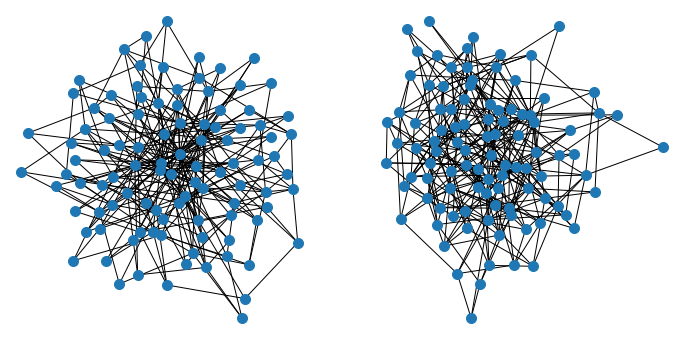

In [15]:
ba = nx.barabasi_albert_graph(100, 3)
er = nx.erdos_renyi_graph(100, 0.06)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
layout = nx.spring_layout(ba, iterations=200)
nx.draw(ba, layout=layout, node_size=100)

plt.subplot(1, 2, 2)
layout = nx.spring_layout(er, iterations=200)
nx.draw(er, layout=layout, node_size=100)

In [20]:
model = DeepWalk(walk_number=20, epochs=10, dimensions=2)
model.fit(ba)
embeddings_ba = model.get_embedding()

model = DeepWalk(walk_number=20, epochs=10, dimensions=2)
model.fit(er)
embeddings_er = model.get_embedding()

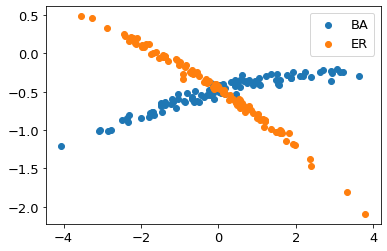

In [21]:
plt.scatter(embeddings_ba[:, 0], embeddings_ba[:, 1], label='BA')
plt.scatter(embeddings_er[:, 0], embeddings_er[:, 1], label='ER')
plt.legend()
plt.show()

**Comparison of Barabasi-Albert and Waltz-Strogatz networks for different network sizes**

In [22]:
sizes = [50, 100, 1000, 5000]

embeddings_ba_networks = []
embeddings_ws_networks = []
k = 6
for s in tqdm(sizes):
    ba = nx.barabasi_albert_graph(s, (int)(k/2))
    ws = nx.newman_watts_strogatz_graph(s, k, 0.05)
    
    model = DeepWalk(epochs=5, dimensions=2)
    model.fit(ba)
    embeddings_ba = model.get_embedding()
    
    model = DeepWalk(epochs=5, dimensions=2)
    model.fit(ws)
    embeddings_ws = model.get_embedding()
    
    embeddings_ba_networks.append(embeddings_ba)
    embeddings_ws_networks.append(embeddings_ws)

100%|██████████| 4/4 [01:41<00:00, 25.45s/it]


In [23]:
def plot_embeddings(pos, s, embeddings_ba, embeddings_ws):
    plt.subplot(*pos)
    plt.scatter(embeddings_ba[:, 0], embeddings_ba[:, 1], label='BA', alpha=0.5)
    plt.scatter(embeddings_ws[:, 0], embeddings_ws[:, 1], label='WS', alpha=0.5)
    plt.legend()

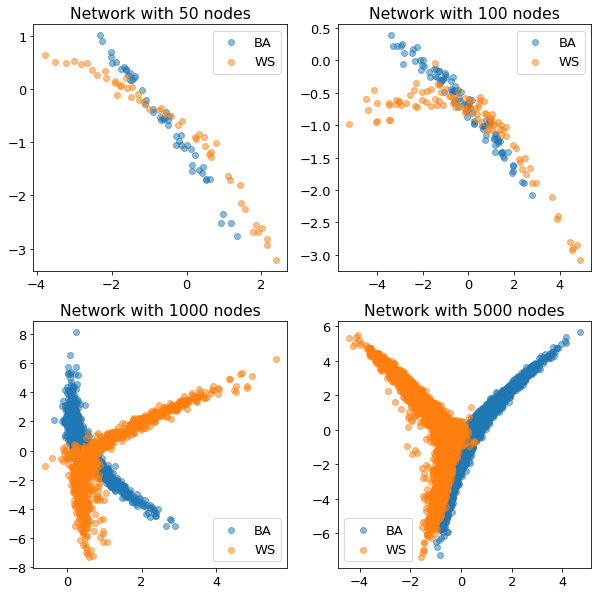

In [24]:
plt.figure(figsize=(10, 10))
for i in range(len(sizes)):
    plot_embeddings((2, 2, i+1), sizes[i], embeddings_ba_networks[i], embeddings_ws_networks[i])
    plt.title('Network with {} nodes'.format(sizes[i]))
plt.show()

**Testing `DeepWalk` on multiple realisations of Barabasi-Albert model**

In [25]:
N = 1000
n_networks = 10

all_embeddings_ba = []

for n in range(n_networks):
    ba = nx.barabasi_albert_graph(N, 3)
    model = DeepWalk(epochs=2, dimensions=2)
    
    model.fit(ba)
    embeddings_ba = model.get_embedding()
    all_embeddings_ba.append(embeddings_ba)

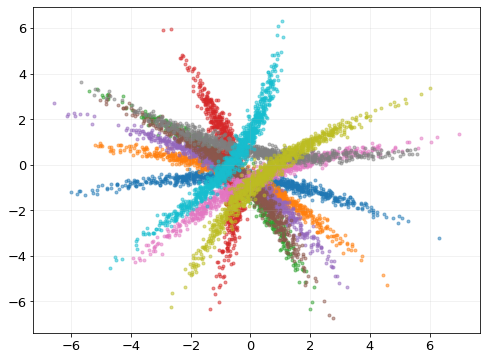

In [26]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.2)
for i in range(n_networks):
    plt.scatter(all_embeddings_ba[i][:, 0], all_embeddings_ba[i][:, 1], marker='.', alpha=0.5)

plt.show()

**Karate network**

In [27]:
karate = nx.karate_club_graph()

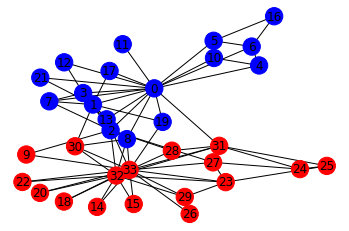

In [28]:
club = ['blue' if club == 'Mr. Hi' else 'red' for club in nx.get_node_attributes(karate, 'club').values()]
nx.draw_networkx(karate, node_color=club)
plt.axis('off')
plt.show()

In [29]:
model = DeepWalk(dimensions=2)
model.fit(karate)

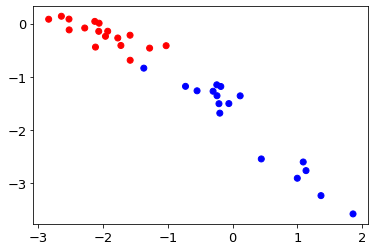

In [30]:
embeddings = model.get_embedding()
plt.scatter(embeddings[:, 0], embeddings[:, 1], color=club)
plt.show()

### Community detection

In [31]:
from karateclub import GraphReader, LabelPropagation

reader = GraphReader('facebook')

graph = reader.get_graph()
target = reader.get_target()

In [32]:
model = LabelPropagation()
model.fit(graph)
cluster_memberships = model.get_memberships()

In [33]:
from sklearn.metrics.cluster import normalized_mutual_info_score

cluster_memberships = [cluster_memberships[node] for node in range(len(cluster_memberships))]

nmi = normalized_mutual_info_score(target, cluster_memberships)

In [34]:
print(f'NMI = {nmi}')

NMI = 0.263391086302391


In [35]:
graph = nx.karate_club_graph()

model = LabelPropagation()
model.fit(graph)
cluster_membership = model.get_memberships()

In [36]:
cluster_membership = [cluster_membership[node] for node in range(len(cluster_membership))]

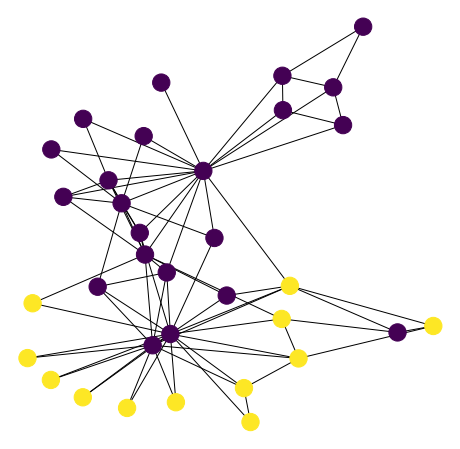

In [37]:
plt.figure(figsize=(8, 8))
nx.draw_networkx(graph, node_color=cluster_membership, with_labels=False)
plt.axis('off')
plt.show()

In [38]:
np.sum(np.array(cluster_membership) ==  np.array([0 if c == 'blue' else 20 for c in club])) / len(cluster_membership)

0.8529411764705882

### Node embedding 

In [39]:
reader = GraphReader('twitch')

graph = reader.get_graph()
y = reader.get_target()

In [43]:
from karateclub import Diff2Vec

model = Diff2Vec(diffusion_number=2, diffusion_cover=20, dimensions=32)
model.fit(graph)
X = model.get_embedding()

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

downstream_model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_hat = downstream_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_hat)
print('AUC: {:.4f}'.format(auc))

AUC: 0.6098


### Graph Embedding

In [50]:
from karateclub.dataset import GraphSetReader

reader = GraphSetReader('reddit10k')

graphs = reader.get_graphs()
y = reader.get_target()

In [67]:
from karateclub import FeatherGraph

model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
downstream_model = LogisticRegression(max_iter=1000, random_state=0).fit(X_train, y_train)
y_hat = downstream_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_hat)
print('AUC: {:.4f}'.format(auc))

AUC: 0.8210
